In [17]:
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [18]:
def KBpriceindex_preprocessing(path, data_type):
    wb = xw.Book(path)
    sheet = wb.sheets[data_type]
    row_num = sheet.range('A1','A1').end('down').end('down').end('down').row
    data_range = 'A2:GE' + str(row_num)
    raw_data = sheet[data_range].options(pd.DataFrame, index=False, header=True).value
    bignames = '서울 대구 부산 대전 광주 인천 울산 세종 경기 강원 충북 충남 전북 전남 경북 경남 제주도 6개광역시 5개광역시 수도권 기타지방 구분 전국'
    bigname_list = bignames.split(' ')
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    for index, gu_data in enumerate(small_col):
        if gu_data == None:
            small_col[index] = big_col[index]
        check = index
        while True:
            if big_col[check] in bigname_list:
                big_col[index] = big_col[check]
                break
            else:
                check = check - 1
    big_col[129] = '경기'
    big_col[130] = '경기'
    small_col[185] = '서귀포'
    raw_data.columns = [big_col, small_col]
    new_col_data = raw_data.drop([0,1])
    new_col_data
    index_list = list(new_col_data['구분']['구분'])
    new_index = []
    for index, raw_index in enumerate(index_list):
        temp = str(raw_index).split('.')
        last = ''
        if int(temp[0]) > 12:
            if len(temp[0]) == 2:
                last = '19' + temp[0] + '.' + temp[1]
                new_index.append(last)
            else:
                last = temp[0] + '.' + temp[1]
                new_index.append(last)
        else:
            last = new_index[index - 1].split('.')[0] + '.' + temp[0]
            new_index.append(last)
    new_col_data.set_index(pd.to_datetime(new_index), inplace=True)
    cleaned_data = new_col_data.drop(('구분', '구분'), axis=1)
    return cleaned_data

In [19]:
# 미분양 데이터를 데이터프레임으로 변환하는 함수
def unsold_preprocessing(path):
    unsold_raw = pd.read_excel(unsold_path, skiprows=1, index_col=0)
    del unsold_raw['시군구']
    transposed_unsold = unsold_raw.T
    transposed_unsold.index = pd.to_datetime(transposed_unsold.index)
    transposed_unsold.columns.name = None
    
    return transposed_unsold

In [32]:
# 인허가 데이터를 데이터프레임으로 변환하는 함수 정의
def permission_preprocessing(path):
    permission_raw = pd.read_excel(permission_path, skiprows=10, index_col=0)
    transposed_permission = permission_raw.T
    new_index = []

    for old_date in transposed_permission.index:
        temp_list = old_date.split(' ')
        new_index.append(temp_list[0][:4] + '.' + temp_list[1][:2])
    transposed_permission.index = pd.to_datetime(new_index)
    transposed_permission.columns.name = None # 날짜 위의 '지역'이라고 쓰여 있는 부분 제거
    
    return transposed_permission

In [33]:
permission_path = r'/Users/gamgoon/Development/ML/realty/주택건설인허가실적.xlsx'
permission = permission_preprocessing(permission_path)
unsold_path = r'/Users/gamgoon/Development/ML/realty/시·군·구별+미분양현황_2082_128_20190623201955.xlsx'
unsold = unsold_preprocessing(unsold_path)
kb_path = r'/Users/gamgoon/Development/ML/realty/★(월간)KB주택가격동향_시계열(2019.05)21667280850300244.xls'
price_index = KBpriceindex_preprocessing(kb_path, '매매종합')
jun_index = KBpriceindex_preprocessing(kb_path, '전세종합')

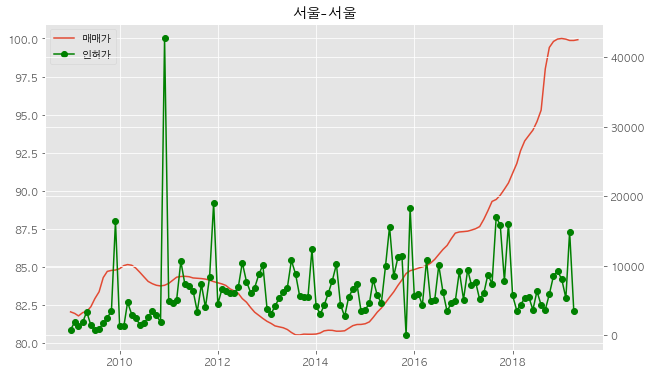

In [35]:
# 매매가 지수와 인허가 데이터를 함께 그래프로 나타내기
plt.figure(figsize=(10, 6))
ax = plt.subplot()
ax2 = ax.twinx() # ax 와 x축만 공유하는 새로운 그래프를 만듬

si = '서울'
gu = '서울'

plt.title(si + '-' + gu)
# ax, ax2에서 plot한 결과를 ln1, ln2로 저장한 이유는 나중에 범례를 표시하기 위해서다. y축이 하나일 떄처럼 범례를 그리면 한쪽 축의 범례만 나오는데,
# 아래와 같이 plot 결과를 저장하고 이를 이용해 범례를 나타내면 양쪽 축의 범례를 모두 표시할 수 있다.
ln1 = ax.plot(price_index[si][gu]['2009-1':], label='매매가')
ln2 = ax2.plot(permission[si]['2009-1':], label='인허가', color='green', marker="o")
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')

plt.show()

In [36]:
# 인허가 데이터를 월별로 선형 그래프로 나타냈더니 상승이나 하락의 추세를 파악하기가 힘들어 보인다. 이를 연으로 묶어서 살펴보겠다.
# 그리고 인허가 데이터가 실제로 부동산 시장에 반영되는 시점은 2년에서 3년 뒤이므로 그래프를 앞으로 2년 정도 옮겨 보자

# 인허가 데이터 연도별로 나타내기
year_permission = permission.groupby(permission.index.year).sum()

In [37]:
year_permission

,전국,서울,부산,대구,인천,광주,대전,울산,경기,강원,충북,충남,전북,전남,경북,경남,제주
2007,555792,62842,41254,18174,41571,13088,11180,24507,198138,10677,19983,29317,11842,15255,24285,31503,2176
2008,371285,48417,13594,22880,33632,3945,14556,5897,115531,13235,10014,21657,12063,10849,15881,24375,4759
2009,381787,36090,6506,6645,59519,5024,1849,6728,159549,12312,11537,22860,11634,8984,13316,17119,2115
2010,386542,69190,18331,4724,37477,4487,4034,4904,143551,9312,8504,15331,12299,17599,13684,18234,4881
2011,549594,88060,37256,12462,35905,16059,19736,13146,148191,12989,18010,46794,16117,15576,16936,39339,13018
2012,586884,86123,42333,13012,32132,19584,6708,9751,151035,12156,24773,44450,24288,22222,25713,44760,10256
2013,440116,77621,29922,18078,18907,8454,5180,5344,96082,12964,19267,32343,13179,20061,23878,34683,6309
2014,515251,65249,17210,19079,13583,11056,5073,12502,163057,12977,16391,35564,13768,17628,41438,49424,8805
2015,765328,101235,33535,27118,30590,14673,7987,12459,276948,18868,31125,40311,22552,15631,53046,45325,18690
2016,726048,74739,36664,23169,22186,22796,13509,16325,244237,29489,29516,31800,28737,20983,36551,61124,21596


In [39]:
# 2년 뒤로 옮긴다
modified_permission = year_permission.shift(2)
temp = []
# 2008, 2009 과 같이 존재하면 파이썬이 시간 형식으로 인식하지 못해서 이를 시간 데이터로 인위적으로 바꿔 준다.
for year in modified_permission.index:
    temp.append(str(year) + '-6-1') # 연 데이터라 한 연도의 가운데에 데이터를 표시하기 위해서
modified_permission.index = pd.to_datetime(temp)


In [40]:
modified_permission

,전국,서울,부산,대구,인천,광주,대전,울산,경기,강원,충북,충남,전북,전남,경북,경남,제주
2007-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-01,555792.0,62842.0,41254.0,18174.0,41571.0,13088.0,11180.0,24507.0,198138.0,10677.0,19983.0,29317.0,11842.0,15255.0,24285.0,31503.0,2176.0
2010-06-01,371285.0,48417.0,13594.0,22880.0,33632.0,3945.0,14556.0,5897.0,115531.0,13235.0,10014.0,21657.0,12063.0,10849.0,15881.0,24375.0,4759.0
2011-06-01,381787.0,36090.0,6506.0,6645.0,59519.0,5024.0,1849.0,6728.0,159549.0,12312.0,11537.0,22860.0,11634.0,8984.0,13316.0,17119.0,2115.0
2012-06-01,386542.0,69190.0,18331.0,4724.0,37477.0,4487.0,4034.0,4904.0,143551.0,9312.0,8504.0,15331.0,12299.0,17599.0,13684.0,18234.0,4881.0
2013-06-01,549594.0,88060.0,37256.0,12462.0,35905.0,16059.0,19736.0,13146.0,148191.0,12989.0,18010.0,46794.0,16117.0,15576.0,16936.0,39339.0,13018.0
2014-06-01,586884.0,86123.0,42333.0,13012.0,32132.0,19584.0,6708.0,9751.0,151035.0,12156.0,24773.0,44450.0,24288.0,22222.0,25713.0,44760.0,10256.0
2015-06-01,440116.0,77621.0,29922.0,18078.0,18907.0,8454.0,5180.0,5344.0,96082.0,12964.0,19267.0,32343.0,13179.0,20061.0,23878.0,34683.0,6309.0
2016-06-01,515251.0,65249.0,17210.0,19079.0,13583.0,11056.0,5073.0,12502.0,163057.0,12977.0,16391.0,35564.0,13768.0,17628.0,41438.0,49424.0,8805.0


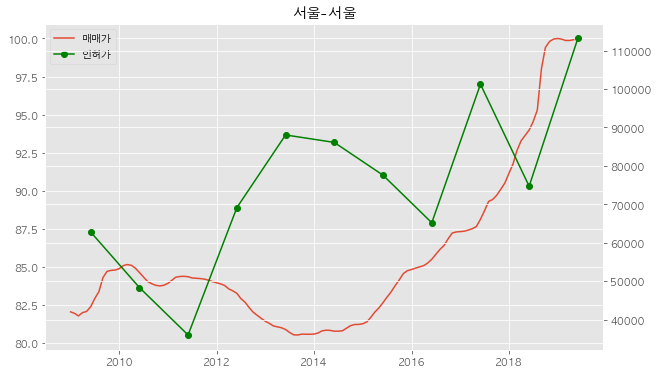

In [42]:
# 매매가 지수와 인허가 데이터를 함께 그래프로 나타내기
plt.figure(figsize=(10, 6))
ax = plt.subplot()
ax2 = ax.twinx() # ax 와 x축만 공유하는 새로운 그래프를 만듬

si = '서울'
gu = '서울'

plt.title(si + '-' + gu)
# ax, ax2에서 plot한 결과를 ln1, ln2로 저장한 이유는 나중에 범례를 표시하기 위해서다. y축이 하나일 떄처럼 범례를 그리면 한쪽 축의 범례만 나오는데,
# 아래와 같이 plot 결과를 저장하고 이를 이용해 범례를 나타내면 양쪽 축의 범례를 모두 표시할 수 있다.
ln1 = ax.plot(price_index[si][gu]['2009-1':], label='매매가')
ln2 = ax2.plot(modified_permission[si]['2009-1':], label='인허가', color='green', marker="o")
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')

plt.show()

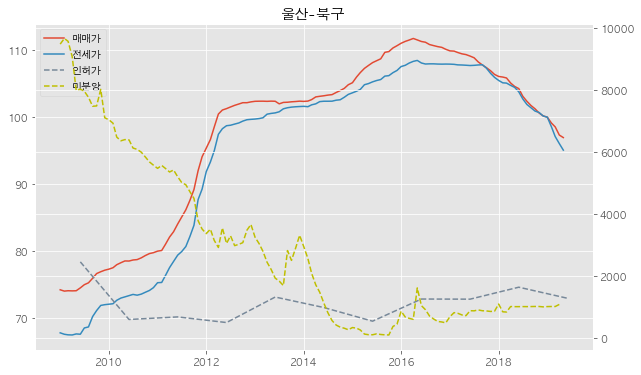

In [60]:
# 미분양 데이터와 전세가 지수 데이터를 추가
# 매매가 지수와 인허가 데이터를 함께 그래프로 나타내기
plt.figure(figsize=(10, 6))
ax = plt.subplot()
ax2 = ax.twinx() # ax 와 x축만 공유하는 새로운 그래프를 만듬

si = '울산'
gu = '북구'

plt.title(si + '-' + gu)
# ax, ax2에서 plot한 결과를 ln1, ln2로 저장한 이유는 나중에 범례를 표시하기 위해서다. y축이 하나일 떄처럼 범례를 그리면 한쪽 축의 범례만 나오는데,
# 아래와 같이 plot 결과를 저장하고 이를 이용해 범례를 나타내면 양쪽 축의 범례를 모두 표시할 수 있다.
ln1 = ax.plot(price_index[si][gu]['2009-1':], label='매매가')
ln2 = ax.plot(jun_index[si][gu]['2009-1':], label='전세가')
# 한 그래프에 데이터가 4개나 들어가므로 명확하게 구분할 수 있게 인허가와 미분양 그래프는 ls='--' 옵션을 추가해서 선이 점선으로 나오게 설정.
# 그리고 인허가 데이터를 10으로 나눴는데 이는 인허가 단위가 미분양 단위보다 훨씬 높아서 조정 없이 그냥 그리면 미분양 그래프의 움직임이 제대로 보이지 않기 때문.
ln3 = ax2.plot(modified_permission[si]['2009-1':]/10, label='인허가', color='lightslategray', ls='--')
ln4 = ax2.plot(unsold[si]['2009':], label='미분양', color='y', ls='--')
lns = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')

plt.show()

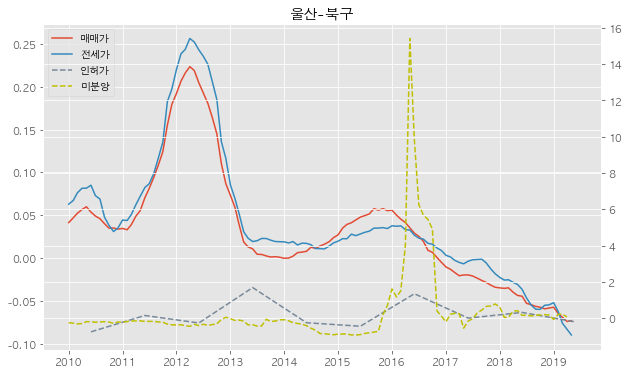

In [61]:
# 변화율로 살펴보기
# 데이터 값 자체가 아니라 변화율을 본다. pandas의 pct_change 함수를 이용 
# 아무런 옵션을 주지 않는다면 바로 앞뒤 데이터의 변화율이 계산되지만 숫자 n을 넣으면 n 간격만큼 떨어진 데이터끼리의 변화율을 계산.
# 월별 변화보다는 연간 변화를 살펴보는 것이 추세를 파악하는 데 도움이 된다고 생각해서 12라는 옵션을 추가. 즉, 연간 변화율을 계산
# 미분양 데이터와 전세가 지수 데이터를 추가
# 매매가 지수와 인허가 데이터를 함께 그래프로 나타내기
plt.figure(figsize=(10, 6))
ax = plt.subplot()
ax2 = ax.twinx() # ax 와 x축만 공유하는 새로운 그래프를 만듬

si = '울산'
gu = '북구'

plt.title(si + '-' + gu)
# ax, ax2에서 plot한 결과를 ln1, ln2로 저장한 이유는 나중에 범례를 표시하기 위해서다. y축이 하나일 떄처럼 범례를 그리면 한쪽 축의 범례만 나오는데,
# 아래와 같이 plot 결과를 저장하고 이를 이용해 범례를 나타내면 양쪽 축의 범례를 모두 표시할 수 있다.
ln1 = ax.plot(price_index[si][gu]['2009-1':].pct_change(12), label='매매가')
ln2 = ax.plot(jun_index[si][gu]['2009-1':].pct_change(12), label='전세가')
ln3 = ax2.plot(modified_permission[si]['2009-1':].pct_change(), label='인허가', color='lightslategray', ls='--')
ln4 = ax2.plot(unsold[si]['2009':].pct_change(12), label='미분양', color='y', ls='--')
lns = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')

plt.show()

In [63]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 수요 전략에 인허가와 미분양 데이터를 추가
def demand(price_index, jeonse_index, index_date, time_range):
    prev_date = index_date - relativedelta(months=time_range)
    prev_date2 = index_date - relativedelta(months=time_range*3)
    demand_df = pd.DataFrame()
    demand_df['매매증감률'] = (price_index.loc[index_date] - price_index.loc[prev_date]) / price_index.loc[prev_date].replace(0,None)
    demand_df['전세증감률'] = (jeonse_index.loc[index_date] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date].replace(0,None)
    demand_df['이전최대값'] = price_index[prev_date2:index_date][:-1].max()
    demand_df['최댓값대비증감률'] = (price_index.loc[index_date] - demand_df['이전최대값']) / demand_df['이전최대값'].replace(0,None)
    demand_df['매매가상승'] = demand_df['매매증감률'] > 0.01
    demand_df['전세가상승'] = demand_df['전세증감률'] > 0.01
    demand_df['더빠른전세상승'] = demand_df['전세증감률'] > demand_df['매매증감률']
    demand_df['최댓값대비상승'] = demand_df['최댓값대비증감률'] > 0
    demand_df['수요총합'] = demand_df[['매매가상승', '전세가상승', '더빠른전세상승', '최댓값대비상승']].sum(axis=1)
    
    demand_df = demand_df[demand_df['수요총합'] == 4]
    
    selected_index = []
    for name in demand_df.index:
        if name[0] is not name[1]:
            selected_index.append((name[0], name[1]))

    demand_df=demand_df.loc[selected_index]
    
    return demand_df

In [64]:
index_date = datetime(2013, 1, 1)
time_range = 12
demand_1 = demand(price_index, jun_index, index_date, time_range)

In [65]:
demand_1

매매증감률      전세증감률       이전최대값     최댓값대비증감률  매매가상승  전세가상승  더빠른전세상승  \
부산 영도구  0.0105916  0.0231865   96.094907  0.000679802   True   True     True   
   연제구  0.0271495  0.0438877   90.282601  0.000141418   True   True     True   
대구 중구   0.0381799  0.0473526   80.969141   0.00302007   True   True     True   
   동구    0.059901  0.0832191   76.263379   0.00435544   True   True     True   
   서구   0.0391477  0.0481874   80.862977    0.0015462   True   True     True   
   북구   0.0808392   0.121241   79.444851    0.0037033   True   True     True   
   수성구  0.0309687  0.0603635   69.659600   0.00202815   True   True     True   
   달서구  0.0766036   0.118091   75.490414   0.00597216   True   True     True   
   달성군  0.0913725   0.115203   80.869389   0.00694921   True   True     True   
광주 동구   0.0314413  0.0402683   89.370661     0.001956   True   True     True   
   서구   0.0401655  0.0459345   77.529566  0.000947088   True   True     True   
   남구   0.0338606  0.0587107   85.682467  8.45907e-05   True   True     True   
   북구   0.0332272  0.0484564   86.939627  0.000925296   True   True     True   
   광산구  0.0449257  0.0757373   81.358856   0.00132932   True   True     True   
울산 남구   0.0516848  0.0608639   93.759913  0.000527829   True   True     True   
   북구   0.0732078  0.0853805  102.278373  0.000840243   True   True     True   
경기 이천   0.0208333   0.041492   93.588009      0.00196   True   True     True   
충북 청주   0.0529109  0.0737586   97.060707   0.00290533   True   True     True   
   상당구  0.0466149  0.0653927  100.530977   0.00568305   True   True     True   
   흥덕구  0.0569288  0.0790754   95.297107   0.00115787   True   True     True   
   충주   0.0283333  0.0462394   98.505446   0.00197854   True   True     True   
충남 천안   0.0834931   0.122239   98.335947   0.00347807   True   True     True   
   동남구  0.0917818   0.123461   96.962410   0.00639117   True   True     True   
   서북구  0.0775694   0.121375   99.455152    0.0013792   True   True     True   
   공주   0.0179989  0.0315939  100.954720  0.000267288   True   True     True   
   아산   0.0779389    0.13861   96.174140   0.00208491   True   True     True   
경북 포항   0.0532139  0.0775433   94.206634   0.00355497   True   True     True   
   북구   0.0713002  0.0974405   94.379928   0.00657981   True   True     True   
   구미    0.096102   0.118327   96.038163    0.0101963   True   True     True   
   경산   0.0907691   0.122536   83.889568   0.00309716   True   True     True   

        최댓값대비상승  수요총합  
부산 영도구     True     4  
   연제구     True     4  
대구 중구      True     4  
   동구      True     4  
   서구      True     4  
   북구      True     4  
   수성구     True     4  
   달서구     True     4  
   달성군     True     4  
광주 동구      True     4  
   서구      True     4  
   남구      True     4  
   북구      True     4  
   광산구     True     4  
울산 남구      True     4  
   북구      True     4  
경기 이천      True     4  
충북 청주      True     4  
   상당구     True     4  
   흥덕구     True     4  
   충주      True     4  
충남 천안      True     4  
   동남구     True     4  
   서북구     True     4  
   공주      True     4  
   아산      True     4  
경북 포항      True     4  
   북구      True     4  
   구미      True     4  
   경산      True     4

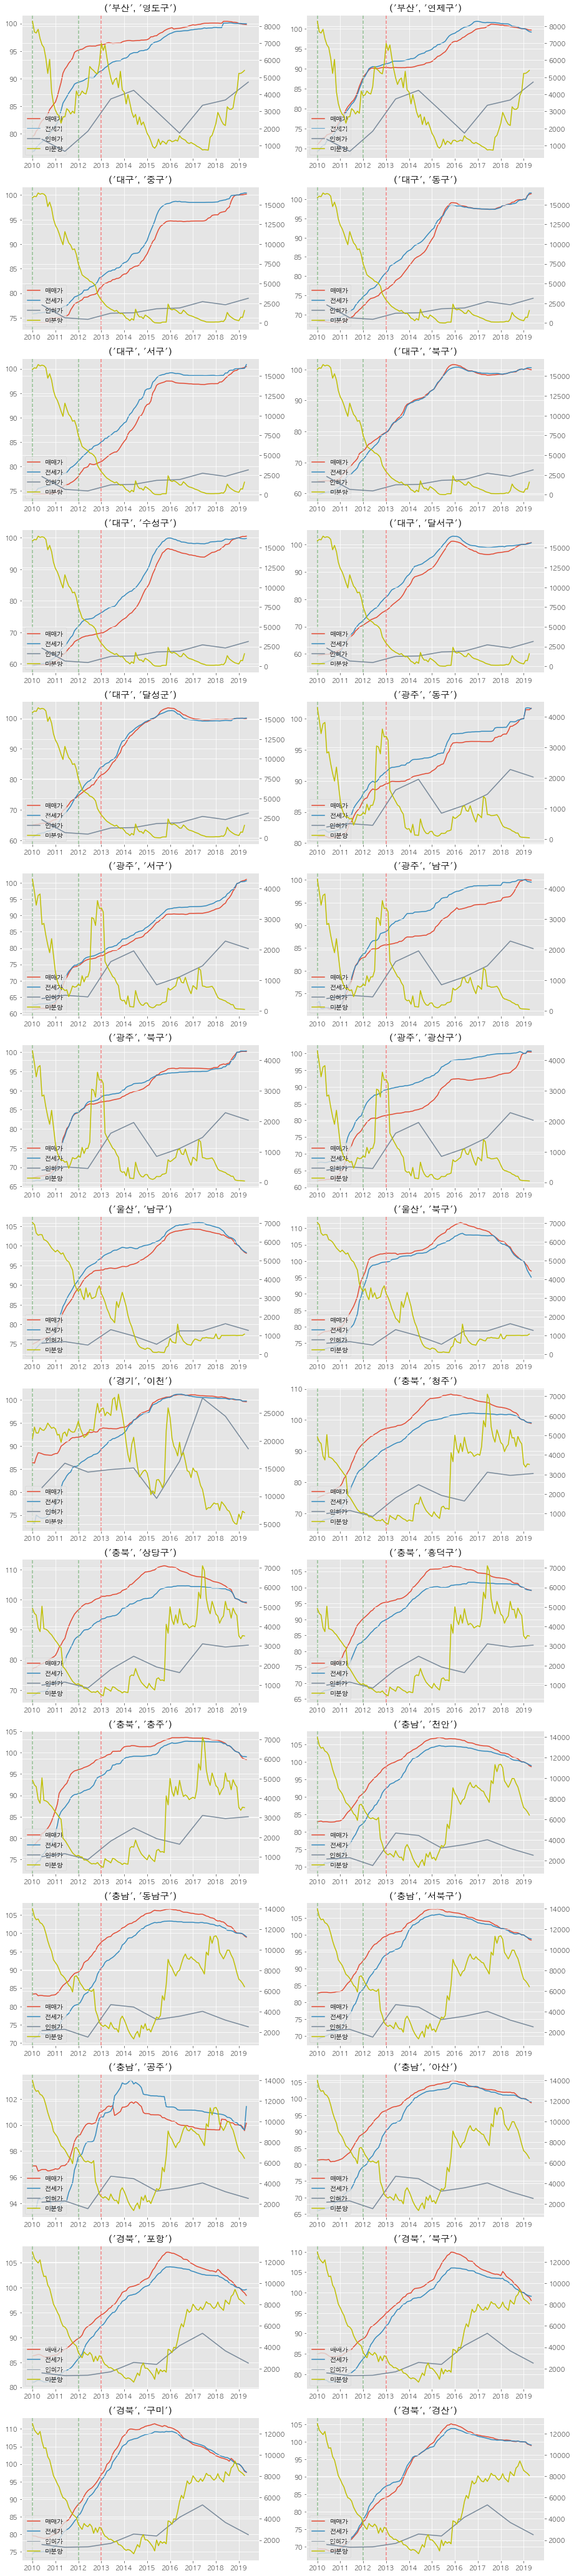

In [68]:
prev_date = index_date - relativedelta(months=time_range)
prev_date2 = index_date - relativedelta(months=time_range * 3)
graph_start = index_date - relativedelta(months=time_range * 3)

num_row = int((len(demand_1.index) - 1) / 2) + 1

plt.figure(figsize=(15, num_row * 5))
for i, spot in enumerate(demand_1.index):
    ax = plt.subplot(num_row, 2, i+1)
    si = spot[0]
    gu = spot[1]
    plt.title(spot)
    ax2 = ax.twinx()
    ln1 = ax.plot(price_index[si][gu][graph_start:], label='매매가')
    ln2 = ax.plot(jun_index[si][gu][graph_start:], label='전세가')
    ln3 = ax2.plot(modified_permission[si][graph_start:]/10, color='lightslategray', label='인허가')
    ln4 = ax2.plot(unsold[si][graph_start:], color='y', label='미분양')
    ax.axvline(x=index_date, color='lightcoral', linestyle='--')
    ax.axvline(x=prev_date, color='darkseagreen', linestyle='--')
    ax.axvline(x=prev_date2, color='darkseagreen', linestyle='--')
    lns = ln1 + ln2 + ln3 + ln4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')
    
plt.show()